# Определение стоимости автомобилей

# Задача

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План

**1. Подготовка данных.**

**2. Обучение моделей.**

**3. Анализ моделей.**

**4. Выводы.**

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
!pip install lightgbm

In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.compose import make_column_transformer

# настройки
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
print('-' * 80)
print('auto_data')
auto_data = import_data('/datasets/autos.csv')

--------------------------------------------------------------------------------
auto_data
Memory usage of dataframe is 43.26 MB
Memory usage after optimization is: 29.74 MB
Decreased by 31.2%


In [6]:
auto_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int16 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int16 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int16 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int32 
 8   RegistrationMonth  354369 non-null  int8  
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int8  
 14  PostalCode         354369 non-null  int32 
 15  LastSeen           354369 non-null  object
dtypes: int16(3), int32(2

### Поправим названия столбцов

In [8]:
clear_auto_data = auto_data.rename(columns={'DateCrawled': 'Date_Crawled', 'VehicleType': 'Vehicle_Type', \
                                            'RegistrationYear': 'Registration_Year', 'RegistrationMonth': 'Registration_Month', \
                                            'FuelType': 'Fuel_Type', 'DateCreated': 'Date_Created', \
                                            'NumberOfPictures': 'Number_Of_Pictures', 'PostalCode': 'Postal_Code', \
                                            'LastSeen': 'Last_Seen'})
clear_auto_data.columns = clear_auto_data.columns.str.lower()
clear_auto_data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Обработаем пропуски

In [9]:
clear_auto_data.isna().sum() / len(auto_data) * 100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Пропуски есть в столбцах 'vehicle_type' - 10,6%, 'gearbox' - 5,6%, 'model' - 5,6%, 'fuel_type' - 9,3%, 'repaired' - 20,1%.

Столбцы 'vehicle_type', 'gearbox' и 'fuel_type' запоним модй в зависимости от модели.

In [10]:
model_auto = clear_auto_data.groupby('model')[['vehicle_type', 'gearbox', 'fuel_type']].agg(pd.Series.mode)
model_auto.head()

,vehicle_type,gearbox,fuel_type
model,,,
100,sedan,manual,petrol
145,small,manual,petrol
147,sedan,manual,petrol
156,wagon,manual,petrol
159,wagon,manual,gasoline


In [11]:
clear_auto_data['vehicle_type'] = clear_auto_data['vehicle_type'].fillna(clear_auto_data['model'].apply(lambda x: model_auto.loc[x][0] if x in model_auto.index else np.nan))

In [12]:
clear_auto_data['vehicle_type'].isna().sum() / len(clear_auto_data) * 100

1.9268051099277872

В столбце 'vehicle_type' пропусков осталось около 2%, удалим их.

In [13]:
clear_auto_data = clear_auto_data.loc[clear_auto_data['vehicle_type'].isna() == False]

In [14]:
clear_auto_data['gearbox'] = clear_auto_data['gearbox'].fillna(clear_auto_data['model'].apply(lambda x: model_auto.loc[x][1] if x in model_auto.index else np.nan))

In [15]:
clear_auto_data['gearbox'].isna().sum() / len(clear_auto_data) * 100

0.32197639990677357

В столбце 'gearbox' пропусков осталось менее 1%, удалим их.

In [16]:
clear_auto_data = clear_auto_data.loc[clear_auto_data['gearbox'].isna() == False]

In [17]:
clear_auto_data['fuel_type'] = clear_auto_data['fuel_type'].fillna(clear_auto_data['model'].apply(lambda x: model_auto.loc[x][2] if x in model_auto.index else np.nan))

In [18]:
clear_auto_data['fuel_type'].isna().sum() / len(clear_auto_data) * 100

0.6694147600325614

В столбце 'fuel_type' пропусков осталось менее 1%, удалим их.

In [19]:
clear_auto_data = clear_auto_data.loc[clear_auto_data['fuel_type'].isna() == False]

In [20]:
clear_auto_data.loc[clear_auto_data['repaired'] == 'no', 'repaired'].count() / len(clear_auto_data) * 100

70.9290532195302

In [21]:
clear_auto_data.loc[clear_auto_data['repaired'] == 'yes', 'repaired'].count() / len(clear_auto_data) * 100

10.170210663667564

In [22]:
clear_auto_data['repaired'] = clear_auto_data['repaired'].fillna(value='no')

In [23]:
clear_auto_data = clear_auto_data.loc[clear_auto_data['model'].isna() == False]

In [24]:
clear_auto_data.isna().sum() / len(auto_data) * 100

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
repaired              0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

In [25]:
#Преобразуем столбец repaired в логиеский тип
clear_auto_data['repaired'] = np.where(clear_auto_data['repaired'] == 'yes', True, False)
clear_auto_data['repaired'].head(20)

0     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11     True
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
Name: repaired, dtype: bool

### Проверим аномалии

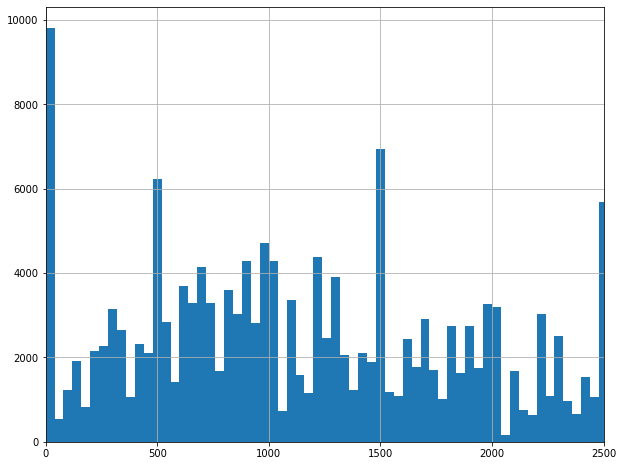

In [26]:
plt.xlim(0, 2500);
clear_auto_data['price'].hist(bins=500, figsize=(10, 8));

Уберем данные, где цена находится в диапазоне от 0 до 500.

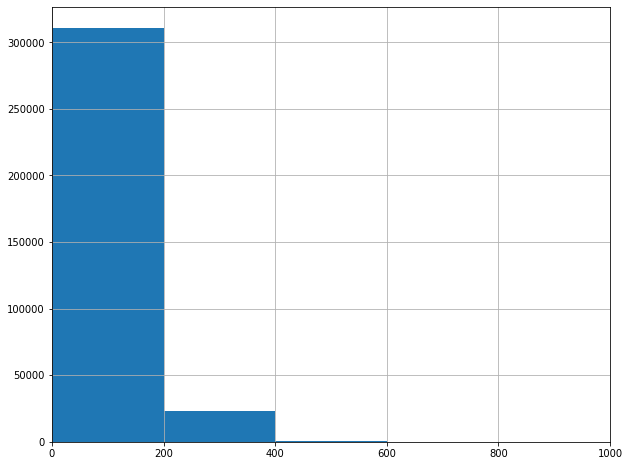

In [27]:
plt.xlim(0, 1000);
clear_auto_data['power'].hist(bins=100, figsize=(10, 8));

Оставим мощность от 1 л.с. до 1000 л.с.

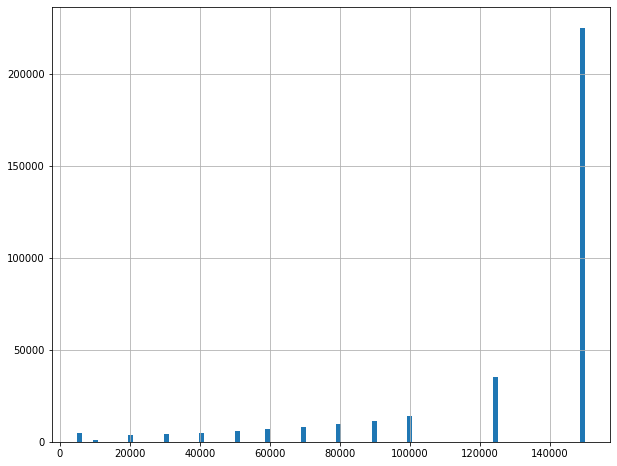

In [28]:
clear_auto_data['kilometer'].hist(bins=100, figsize=(10, 8));

У пробега аномальных значений нет.

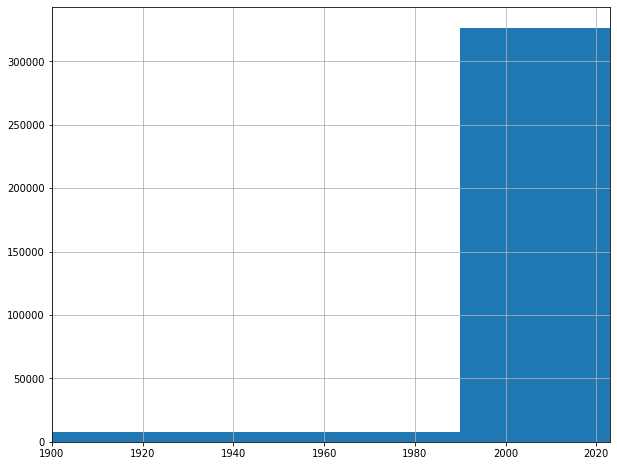

In [29]:
plt.xlim(1900, 2023);
clear_auto_data['registration_year'].hist(bins=100, figsize=(10, 8));

Год выпуска оставим в диапазоне от 1900 до 2023.

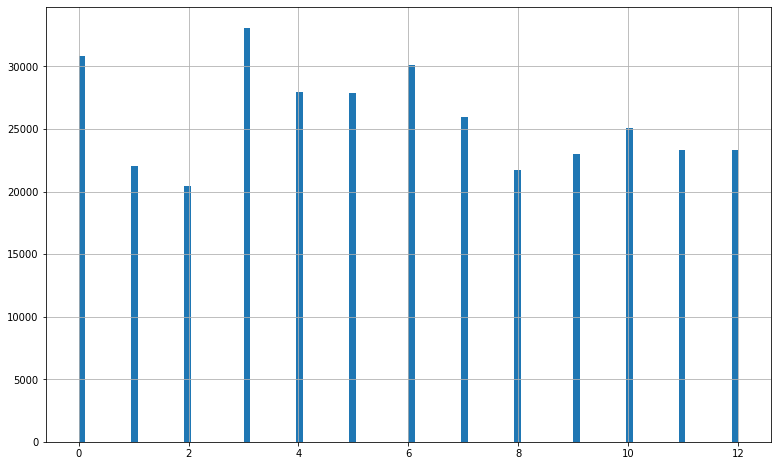

In [30]:
clear_auto_data['registration_month'].hist(bins=100, figsize=(13, 8));

Также удалим данные, в которых месяц равен 0.

Теперь избавимся от обнаруженных аномалий.

In [31]:
clear_auto_data = clear_auto_data.loc[clear_auto_data['price'] >= 500]
clear_auto_data = clear_auto_data.loc[(clear_auto_data['power'] <= 1000) & (clear_auto_data['power'] >= 1)]
clear_auto_data = clear_auto_data.loc[(clear_auto_data['registration_year'] > 1900) & (clear_auto_data['registration_year'] <= 2023)]
clear_auto_data = clear_auto_data.loc[clear_auto_data['registration_month'] > 0]
clear_auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264221 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        264221 non-null  object
 1   price               264221 non-null  int16 
 2   vehicle_type        264221 non-null  object
 3   registration_year   264221 non-null  int16 
 4   gearbox             264221 non-null  object
 5   power               264221 non-null  int16 
 6   model               264221 non-null  object
 7   kilometer           264221 non-null  int32 
 8   registration_month  264221 non-null  int8  
 9   fuel_type           264221 non-null  object
 10  brand               264221 non-null  object
 11  repaired            264221 non-null  bool  
 12  date_created        264221 non-null  object
 13  number_of_pictures  264221 non-null  int8  
 14  postal_code         264221 non-null  int32 
 15  last_seen           264221 non-null  object
dtypes:

In [32]:
clear_auto_data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,264221.000000,264221.000000,264221.000000,264221.000000,264221.000000,264221.0,264221.000000
mean,5237.062069,2003.670041,122.981137,127471.567362,6.398152,0.0,51558.698533
std,4625.692043,6.529884,54.063813,36843.859437,3.347850,0.0,25686.910565
min,500.000000,1910.000000,1.000000,5000.000000,1.000000,0.0,1067.000000
25%,1600.000000,2000.000000,82.000000,125000.000000,4.000000,0.0,31224.000000
50%,3600.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50823.000000
75%,7500.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72280.000000
max,20000.000000,2019.000000,1000.000000,150000.000000,12.000000,0.0,99998.000000


### Проверим зависимости между параметрами

In [33]:
clear_auto_data.corr()

,price,registration_year,power,kilometer,registration_month,repaired,number_of_pictures,postal_code
price,1.000000,0.458730,0.489242,-0.400595,0.007936,-0.160614,NaN,0.059211
registration_year,0.458730,1.000000,0.094049,-0.306132,0.000612,-0.068296,NaN,0.012870
power,0.489242,0.094049,1.000000,0.122466,0.020073,-0.011301,NaN,0.048908
kilometer,-0.400595,-0.306132,0.122466,1.000000,0.007849,0.068550,NaN,-0.009625
registration_month,0.007936,0.000612,0.020073,0.007849,1.000000,-0.008765,NaN,-0.007503
repaired,-0.160614,-0.068296,-0.011301,0.068550,-0.008765,1.000000,NaN,0.008135
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.059211,0.012870,0.048908,-0.009625,-0.007503,0.008135,NaN,1.000000


По матрице корреляций мы видим, что есть зависимость цены от мощности, пробега и факта ремонта. с остальными числовыми признаками значимой зависимости нет, поэтому для модели оставим только мощность, пробег и факт ремонта.

Из набора категориальных признаков оставим тип автомобильного кузова, тип коробки передач, модель автомобиля, тип топлива, марка автомобиля.

Уберем дату скачивания анкеты из базы, год регистрации автомобиля, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя.

In [34]:
clear_auto_data = clear_auto_data.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', \
                                        'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
clear_auto_data.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,auto,163,grand,125000,gasoline,jeep,False
3,1500,small,manual,75,golf,150000,petrol,volkswagen,False
4,3600,small,manual,69,fabia,90000,gasoline,skoda,False
5,650,sedan,manual,102,3er,150000,petrol,bmw,True
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,False


**Промежуточные выводы**

Мы исправили названия столбцов, обработали пропуски, избавились от аномальных значений, построили матрицу корреляций для количественных признаков и сотавили для модели только те, которые имеют значимую корреляцию с целевым признаком. Также иы избавились от ненужных категориальных признаков.

## Обучение моделей

### Подготовим выборки для моделей

In [35]:
clear_auto_data['vehicle_type'] = clear_auto_data['vehicle_type'].astype('str')
clear_auto_data['gearbox'] = clear_auto_data['gearbox'].astype('str')
clear_auto_data['fuel_type'] = clear_auto_data['fuel_type'].astype('str')
clear_auto_data.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,auto,163,grand,125000,gasoline,jeep,False
3,1500,small,manual,75,golf,150000,petrol,volkswagen,False
4,3600,small,manual,69,fabia,90000,gasoline,skoda,False
5,650,sedan,manual,102,3er,150000,petrol,bmw,True
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,False


In [36]:
features = clear_auto_data.drop('price', axis=1)
target = clear_auto_data['price']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, \
                                                                          random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, \
                                                                          random_state=RANDOM_STATE)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(158532, 8)
(158532,)
(52845, 8)
(52845,)
(52844, 8)
(52844,)


### Линейная модель

In [37]:
#категориальные признаки для линейной регрессии
ohe_features_linear = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_linear)

#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = ohe_features_linear.copy()
ohe_features_rf.remove('model')
ohe_features_rf

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']


['vehicle_type', 'gearbox', 'fuel_type', 'brand']

In [38]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')
num_features

['power', 'kilometer']

In [39]:
features_train_linear = features_train.copy()
features_valid_linear = features_valid.copy()
features_test_linear = features_test.copy()

In [40]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
col_transformer_linear = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_linear
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

features_train_linear = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_linear.fit_transform(features_train_linear),
    columns=col_transformer_linear.get_feature_names_out()
)

# смотрим на результат
features_train_linear.head()

,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,...,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,power,kilometer,repaired
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.408395,0.610974,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.334167,-2.916247,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.148318,0.610974,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742145,0.610974,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.024669,0.610974,0.0


In [41]:
# трансформируем валидационную выборку
features_valid_linear = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_linear.transform(features_valid_linear),
    columns=col_transformer_linear.get_feature_names_out()
)

# смотрим на результат
features_valid_linear.head()

,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,...,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,power,kilometer,repaired
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.280579,0.610974,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148318,0.610974,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001945,-2.102273,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.872045,-1.288299,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872045,0.610974,0.0


In [42]:
linear_model = LinearRegression()
%time linear_model.fit(features_train_linear, target_train)
%time linear_predictions = linear_model.predict(features_valid_linear)
linear_mse = mean_squared_error(target_valid, linear_predictions)
linear_rmse = linear_mse ** 0.5
print('средняя предсказанная цена:', linear_predictions.mean())
print('RMSE:', linear_rmse)

CPU times: user 15.2 s, sys: 17.8 s, total: 32.9 s
Wall time: 33.1 s
CPU times: user 185 ms, sys: 55.3 ms, total: 240 ms
Wall time: 249 ms
средняя предсказанная цена: 5264.469949095736
RMSE: 2878.3129820467693


Время обучения: ~52.9 s

Время предсказания: ~212 ms

RMSE: 2878.3

### Константная модель

In [43]:
dummy_model = DummyRegressor(strategy="median")
%time dummy_model.fit(features_train_linear, target_train)
%time dummy_predict = dummy_model.predict(features_valid_linear)
dummy_mse = mean_squared_error(target_valid, dummy_predict)
dummy_rmse = dummy_mse ** 0.5
print('средняя предсказанная цена:', pd.Series(dummy_predict).median())
print('RMSE:', dummy_rmse)

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 2.73 ms
CPU times: user 511 µs, sys: 109 µs, total: 620 µs
Wall time: 439 µs
средняя предсказанная цена: 3600.0
RMSE: 4959.885883201086


Время обучения: ~3.72 ms

Время предсказания: ~661 µs

RMSE: 4959.8

### Модель случайного леса

In [44]:
best_rf_model = 0
best_est = 0
best_depth = 0
rf_rmse = 10000

i_depth = [None] + [i for i in range(5, 7)]

for est in range(50, 101, 50):
    for depth in i_depth:
        rf_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        print('Время обучения:')
        %time rf_model.fit(features_train_linear, target_train)
        %time rf_predictions = rf_model.predict(features_valid_linear)
        print('Время предсказания:')
        rf_mse = mean_squared_error(target_valid, rf_predictions)
        rmse = rf_mse ** 0.5
        print('est:', est, 'depth:', depth, 'rmse:', rmse)
        print()
        if rmse < rf_rmse:
            best_rf_model = rf_model
            best_est = est
            best_depth = depth
            rf_rmse = rmse
print('est:', best_est, 'depth:', best_depth, 'rmse:', rf_rmse)

Время обучения:
CPU times: user 8min 22s, sys: 911 ms, total: 8min 23s
Wall time: 8min 23s
CPU times: user 803 ms, sys: 6.88 ms, total: 810 ms
Wall time: 812 ms
Время предсказания:
est: 50 depth: None rmse: 2100.7310802351194

Время обучения:
CPU times: user 11.6 s, sys: 21.5 ms, total: 11.6 s
Wall time: 11.6 s
CPU times: user 140 ms, sys: 13 µs, total: 140 ms
Wall time: 141 ms
Время предсказания:
est: 50 depth: 5 rmse: 2953.2988157276986

Время обучения:
CPU times: user 18.3 s, sys: 10.4 ms, total: 18.3 s
Wall time: 18.3 s
CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 158 ms
Время предсказания:
est: 50 depth: 6 rmse: 2852.341433861779

Время обучения:
CPU times: user 16min 43s, sys: 1.19 s, total: 16min 44s
Wall time: 16min 44s
CPU times: user 1.59 s, sys: 4.01 ms, total: 1.59 s
Wall time: 1.59 s
Время предсказания:
est: 100 depth: None rmse: 2097.14977197043

Время обучения:
CPU times: user 23.4 s, sys: 4.41 ms, total: 23.4 s
Wall time: 23.4 s
CPU times: user 238 ms, sy

In [45]:
features_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158532 entries, 0 to 158531
Columns: 305 entries, vehicle_type_bus to repaired
dtypes: Sparse[float64, 0](305)
memory usage: 12.4 MB


Время обучения: ~18min 30s

Время предсказания: ~1.55 s

RMSE: 2097.14

### Модель градиентного бустинга LightGBM

In [46]:
features_train_linear = features_train_linear.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
features_valid_linear = features_valid_linear.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [47]:
features_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158532 entries, 0 to 158531
Columns: 305 entries, vehicle_type_bus to repaired
dtypes: Sparse[float64, 0](305)
memory usage: 12.4 MB


In [48]:
best_lgbm_model = LGBMRegressor()
best_lgbm_est = 0
best_lgbm_depth = 0
lgbm_rmse = 10000

i_depth = [None] + [i for i in range(5, 7)]

for est in range(10, 21, 10):
    for depth in i_depth:
        lgbm_model = LGBMRegressor(random_state=RANDOM_STATE, max_depth=depth)
        print('Время обучения:')
        %time lgbm_model.fit(features_train_linear, target_train)
        print('Время предсказания:')
        %time lgbm_predictions = lgbm_model.predict(features_valid_linear)
        lgbm_mse = mean_squared_error(target_valid, lgbm_predictions)
        rmse = lgbm_mse ** 0.5
        print('est:', est, 'depth:', depth, 'rmse:', rmse)
        print()
        if rmse < lgbm_rmse:
            best_lgbm_model = lgbm_model
            best_lgbm_est = est
            best_lgbm_depth = depth
            lgbm_rmse = rmse
print('est:', best_lgbm_est, 'depth:', best_lgbm_depth, 'rmse:', lgbm_rmse)

Время обучения:
CPU times: user 7.24 s, sys: 309 ms, total: 7.54 s
Wall time: 7.58 s
Время предсказания:
CPU times: user 641 ms, sys: 30.5 ms, total: 672 ms
Wall time: 618 ms
est: 10 depth: None rmse: 2409.515893501116

Время обучения:
CPU times: user 5.31 s, sys: 218 ms, total: 5.53 s
Wall time: 5.58 s
Время предсказания:
CPU times: user 388 ms, sys: 35 ms, total: 423 ms
Wall time: 410 ms
est: 10 depth: 5 rmse: 2548.5631908378764

Время обучения:
CPU times: user 4.85 s, sys: 238 ms, total: 5.09 s
Wall time: 5.1 s
Время предсказания:
CPU times: user 465 ms, sys: 30.3 ms, total: 495 ms
Wall time: 505 ms
est: 10 depth: 6 rmse: 2498.4905212350386

Время обучения:
CPU times: user 6.83 s, sys: 274 ms, total: 7.1 s
Wall time: 7.19 s
Время предсказания:
CPU times: user 658 ms, sys: 38.6 ms, total: 696 ms
Wall time: 709 ms
est: 20 depth: None rmse: 2409.515893501116

Время обучения:
CPU times: user 4.55 s, sys: 250 ms, total: 4.8 s
Wall time: 4.8 s
Время предсказания:
CPU times: user 393 ms, s

Время обучения: ~5.69 s

Время предсказания: ~704 ms

RMSE: 2409.5

**Промежуточные выводы**


Лучший rmse показала модель случайного леса: 2097.14. Затем модель градиентного бустинга: 2409.5. Модель линейной регрессии: 2878.3.

Лучшее время обучения у градиентного бустинга: 5.69 s, Затем у линейной регрессии: 52.9 s. и у случайного леса 18min 30s.

Лучшее время предсказания у линейной регрессии: 91.5 ms. Затем у градиентного бустинга 704 ms. И у случайного леса 47.4 s.

В требованиях заказчика указано, что rmse должна быть меньше 2500. этому требованию удовлетворет модель слуайного леса и градиентного бустинга. Время на предсказание и обучение нужно минимозировать, но при этом оставить качество модели. Поэтому мы выберем модель градиентного бустинга, она дает хороший результат по всем критериям.

## Анализ моделей

Проверим модель градиентного бустинга на тестовой выборке.

In [49]:
# трансформируем тестовую выборку
features_test_linear = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_linear.transform(features_test_linear),
    columns=col_transformer_linear.get_feature_names_out()
)

# смотрим на результат
features_test_linear.head()

,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,...,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,power,kilometer,repaired
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.018696,-2.102273,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.334167,0.610974,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.798094,-1.559623,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.334167,0.610974,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742145,0.610974,0.0


In [50]:
features_test_linear = features_test_linear.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [51]:
features_test_linear.head()

,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,...,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,power,kilometer,repaired
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.018696,-2.102273,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.334167,0.610974,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.798094,-1.559623,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.334167,0.610974,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.742145,0.610974,0.0


In [52]:
lgbm_predictions = best_lgbm_model.predict(features_test_linear)
lgbm_mse = mean_squared_error(target_test, lgbm_predictions)
rmse = lgbm_mse ** 0.5
print(rmse)

2373.216119849325


## Выводы

В ходе работы были выполнены следующие этапы:
1. Предобработка и анализ данных:
- исправлены названия столбцов;
- обработаны пропуски;
- устранены аномальные значения;
- для модели выбраны только те количественные признаки, которые имеют значимую корреляцию с целевым признаком. Также мы избавились от ненужных категориальных признаков.
2. Пострение моделей:
- Данные были разделены на обучающую и тестовую выборки;
- проведено масштабирование и кодирование данных;
- построена линейная модель, которая показала rmse - 2878.3, время обучения - 52.9 s, время предсказания: 91.5 ms;
- построена модель случайного леса, которая показала rmse - 2097.14, время обучения - 23min 33s, время предсказания: 6.82 s;
- построена модель градиентного бустинга, которая показала rmse - 2409.5, время обучения:  5.69 s, время предсказания - 2.73 s;
- также была проверена константная модель, которая показала rmse - 4959.8, время обучения: 3.16 ms, время предсказания - 661 µs.
3. Выбор модели:
- В соответствии с требованиями заказчика, мы рекомендуем выбрать модель градиентного бустинга.
4. проверка модели градиентного бустинга на тестовой выборке:
- на тестовой выборке модель градиентного бустинга показала rmse - 2373.2.